# Proyek Klasifikasi Gambar: [Flowers Dataset]
- **Nama:** Mohammad 'Alwan Fauzi
- **Email:** alwanfauzi111@gmail.com
- **ID Dicoding:** MC006D5Y1380

## Import Semua Packages/Library yang Digunakan

In [1]:
# Built-in
import os
import shutil
import random
import zipfile
import subprocess

# Data handling
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model & training
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.15.0


## Data Preparation

### Data Loading

In [3]:
zip_path = "dataset.zip"
extract_path = "flowers_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset berhasil diekstrak ke:", extract_path)

Dataset berhasil diekstrak ke: flowers_dataset


### Data Preprocessing

#### Split Dataset

In [4]:
original_dataset_dir = "flowers_dataset"
base_dir = "flowers_split"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

train_split = 0.7
val_split = 0.15
test_split = 0.15

classes = os.listdir(original_dataset_dir)
for class_name in classes:
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_split)
    n_val = int(n_total * val_split)

    train_images = images[:n_train]
    val_images = images[n_train:n_train + n_val]
    test_images = images[n_train + n_val:]

    for image_list, target_dir in zip(
        [train_images, val_images, test_images],
        [train_dir, val_dir, test_dir]
    ):
        class_target_dir = os.path.join(target_dir, class_name)
        os.makedirs(class_target_dir, exist_ok=True)
        for img_name in image_list:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(class_target_dir, img_name)
            shutil.copyfile(src, dst)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

image_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2567 images belonging to 5 classes.
Found 547 images belonging to 5 classes.
Found 556 images belonging to 5 classes.


## Modelling

In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
num_classes = train_generator.num_classes

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze awal

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [8]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy')
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25


81/81 [==============================] - 192s 2s/step - loss: 1.3408 - accuracy: 0.4881 - val_loss: 0.7729 - val_accuracy: 0.7459
Epoch 2/25
81/81 [==============================] - 127s 2s/step - loss: 0.8321 - accuracy: 0.6907 - val_loss: 0.5827 - val_accuracy: 0.8172
Epoch 3/25
81/81 [==============================] - 140s 2s/step - loss: 0.6578 - accuracy: 0.7628 - val_loss: 0.5097 - val_accuracy: 0.8336
Epoch 4/25
81/81 [==============================] - 126s 2s/step - loss: 0.5923 - accuracy: 0.7830 - val_loss: 0.4593 - val_accuracy: 0.8647
Epoch 5/25
81/81 [==============================] - 126s 2s/step - loss: 0.5293 - accuracy: 0.8091 - val_loss: 0.4273 - val_accuracy: 0.8665
Epoch 6/25
81/81 [==============================] - 125s 2s/step - loss: 0.5032 - accuracy: 0.8099 - val_loss: 0.4103 - val_accuracy: 0.8757
Epoch 7/25
81/81 [==============================] - 121s 1s/step - loss: 0.4772 - accuracy: 0.8321 - val_loss: 0.3984 - val_accuracy: 0.8757
Epoch 8/25


## Evaluasi dan Visualisasi

In [9]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

18/18 [==============================] - 20s 1s/step - loss: 0.2897 - accuracy: 0.9011

Test Accuracy: 90.11%
Test Loss: 0.2897


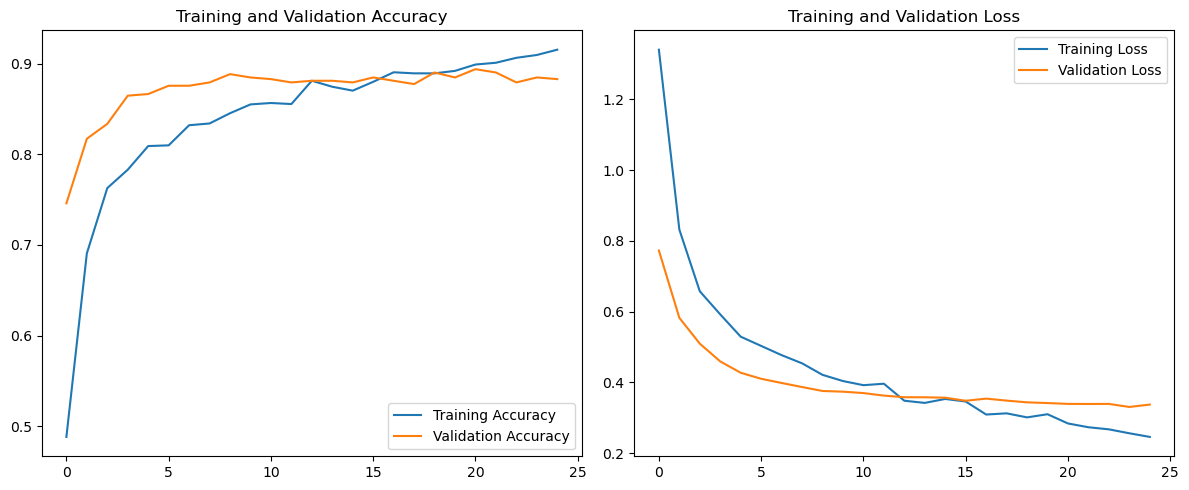

In [10]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

18/18 [==============================] - 16s 758ms/step
Classification Report:

              precision    recall  f1-score   support

       daisy       0.91      0.90      0.91        96
   dandelion       0.91      0.96      0.93       136
       roses       0.88      0.84      0.86        97
  sunflowers       0.91      0.91      0.91       106
      tulips       0.89      0.89      0.89       121

    accuracy                           0.90       556
   macro avg       0.90      0.90      0.90       556
weighted avg       0.90      0.90      0.90       556



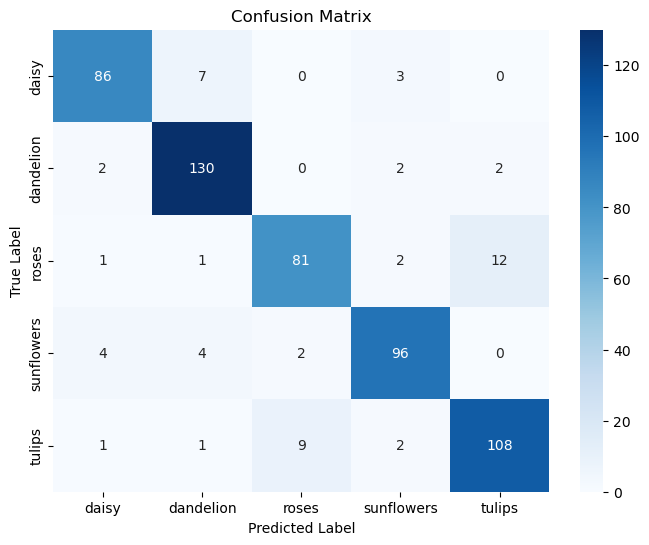

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)

report = classification_report(true_labels, pred_classes, target_names=class_names)
print("Classification Report:\n")
print(report)

cm = confusion_matrix(true_labels, pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Konversi Model

In [12]:
# Simpan model dalam format SavedModel
saved_model_dir = "saved_model"
model.save(saved_model_dir)
print(f"Model disimpan dalam format SavedModel di folder: {saved_model_dir}")


INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Model disimpan dalam format SavedModel di folder: saved_model


In [13]:
import tensorflow as tf

# Konversi ke TFLite
tflite_converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = tflite_converter.convert()

# Simpan ke file
tflite_model_path = "model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Model berhasil dikonversi ke TFLite dan disimpan sebagai: {tflite_model_path}")


Model berhasil dikonversi ke TFLite dan disimpan sebagai: model.tflite


In [14]:
import subprocess

tfjs_target_dir = "tfjs_model"

# Konversi ke format TFJS
subprocess.run([
    "tensorflowjs_converter",
    "--input_format", "tf_saved_model",
    "--output_format", "tfjs_graph_model",
    "--signature_name", "serving_default",
    "--saved_model_tags", "serve",
    saved_model_dir,
    tfjs_target_dir
])

print(f"Model berhasil dikonversi ke TensorFlow.js di folder: {tfjs_target_dir}")

Model berhasil dikonversi ke TensorFlow.js di folder: tfjs_model


## Inference (Optional)